# Install Transformers Library

In [ ]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [3]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
df.shape

(5572, 2)

In [4]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [5]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [6]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [7]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [8]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

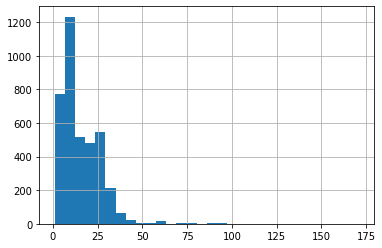

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [10]:
max_seq_len = 25

In [11]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [12]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [14]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [16]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [17]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [19]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [20]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [21]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [22]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [23]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.526
Validation Loss: 0.656

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.345
Validation Loss: 0.231

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.344
Validation Loss: 0.194

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.223
Validation Loss: 0.171

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.219
Validation Loss: 0.178

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.215
Validation Loss: 0.180

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.247
Validation Loss: 0.262

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.224
Validat

# Load Saved Model

In [24]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [25]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [26]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       724
           1       0.88      0.92      0.90       112

    accuracy                           0.97       836
   macro avg       0.93      0.95      0.94       836
weighted avg       0.97      0.97      0.97       836



In [27]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,710,14
1,9,103


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
import numpy as np

class SentenceEncoder(nn.Module):
    """
    Sentence encoder module that encodes a sentence containing entities into a feature vector.
    It uses BERT as embedding layer and CNN as encoding layer.
    """
    def __init__(self, pretrained_bert="bert-base-uncased", hidden_size=768, max_length=64):
        super(SentenceEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(pretrained_bert)
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_bert)
        
        # CNN layer
        self.conv = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
    
    def forward(self, inputs):
        """
        Args:
            inputs: List of sentences with marked entity positions
        
        Returns:
            Sentence embeddings
        """
        # Process input sentences with BERT
        encoded_inputs = self.tokenizer(
            inputs,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        outputs = self.bert(
            input_ids=encoded_inputs["input_ids"].to(self.bert.device),
            attention_mask=encoded_inputs["attention_mask"].to(self.bert.device),
            token_type_ids=encoded_inputs["token_type_ids"].to(self.bert.device)
        )
        
        # Get the word embeddings from BERT
        word_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Apply CNN
        word_embeddings = word_embeddings.transpose(1, 2)  # [batch_size, hidden_size, seq_len]
        conv_output = self.conv(word_embeddings)  # [batch_size, hidden_size, seq_len]
        
        # Max pooling
        sentence_embeddings = F.max_pool1d(conv_output, kernel_size=conv_output.size(2))  # [batch_size, hidden_size, 1]
        sentence_embeddings = sentence_embeddings.squeeze(2)  # [batch_size, hidden_size]
        
        return sentence_embeddings

class ContextAttention(nn.Module):
    """
    Context attention mechanism to highlight crucial instances in support set.
    """
    def __init__(self, hidden_size=768, num_heads=12):
        super(ContextAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        assert self.head_dim * num_heads == hidden_size, "hidden_size must be divisible by num_heads"
    
    def forward(self, support_set):
        """
        Args:
            support_set: Support set embeddings [N, K, hidden_size]
            
        Returns:
            Weighted support set embeddings [N, K, hidden_size]
        """
        N, K, D = support_set.size()  # N relations, K instances per relation, D hidden size
        
        # Reshape for multi-head attention
        support_set = support_set.view(N, K, self.num_heads, self.head_dim)
        support_set = support_set.permute(0, 2, 1, 3)  # [N, num_heads, K, head_dim]
        
        # Calculate scaled dot-product attention
        attention_scores = torch.matmul(support_set, support_set.transpose(-1, -2))  # [N, num_heads, K, K]
        attention_scores = attention_scores / (self.head_dim ** 0.5)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)  # [N, num_heads, K, K]
        
        # Apply attention weights to support set
        weighted_support = torch.matmul(attention_weights, support_set)  # [N, num_heads, K, head_dim]
        
        # Reshape back
        weighted_support = weighted_support.permute(0, 2, 1, 3)  # [N, K, num_heads, head_dim]
        weighted_support = weighted_support.reshape(N, K, D)  # [N, K, hidden_size]
        
        return weighted_support

class ProtoCABTwithBERT(nn.Module):
    """
    Context Attention-based Prototypical Networks with BERT for few-shot relation classification.
    """
    def __init__(self, pretrained_bert="bert-base-uncased", hidden_size=768, num_heads=12):
        super(ProtoCABTwithBERT, self).__init__()
        self.hidden_size = hidden_size
        
        # Sentence encoder
        self.encoder = SentenceEncoder(pretrained_bert, hidden_size)
        
        # Context attention
        self.context_attention = ContextAttention(hidden_size, num_heads)
    
    def forward(self, support, query):
        """
        Args:
            support: Support set, N relations with K instances each
                     [N, K] list of sentences
            query: Query instance, a sentence
            
        Returns:
            Relation probabilities for the query
        """
        N = len(support)  # Number of relations
        K = len(support[0])  # Number of instances per relation
        
        # Flatten support set for batch processing
        support_flat = [instance for relation in support for instance in relation]
        
        # Encode support set instances
        support_embeddings = self.encoder(support_flat)
        support_embeddings = support_embeddings.view(N, K, -1)  # [N, K, hidden_size]
        
        # Apply context attention to get weighted support embeddings
        support_embeddings = self.context_attention(support_embeddings)  # [N, K, hidden_size]
        
        # Calculate prototypes for each relation
        prototypes = torch.mean(support_embeddings, dim=1)  # [N, hidden_size]
        
        # Encode query instance
        query_embedding = self.encoder([query])  # [1, hidden_size]
        
        # Calculate distances between query and prototypes
        distances = torch.sum((query_embedding.unsqueeze(1) - prototypes.unsqueeze(0)) ** 2, dim=2)  # [1, N]
        distances = distances.squeeze(0)  # [N]
        
        # Calculate probabilities using softmax with negative distances
        logits = -distances
        probabilities = F.softmax(logits, dim=0)
        
        return probabilities

# Training function
def train(model, train_data, val_data, epochs=10000, lr=2e-5, n_way=5, k_shot=5):
    """
    Train the model for few-shot relation classification.
    
    Args:
        model: The model to train
        train_data: Training data organized by relations
        val_data: Validation data organized by relations
        epochs: Number of training iterations
        lr: Learning rate
        n_way: Number of relations in each episode
        k_shot: Number of instances per relation in support set
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Sample classes for this episode
        sampled_relations = np.random.choice(len(train_data), n_way, replace=False)
        
        # Prepare support set and query set
        support = []
        query_examples = []
        query_labels = []
        
        for i, rel_id in enumerate(sampled_relations):
            instances = train_data[rel_id]
            # Randomly select k_shot instances for support set
            support_indices = np.random.choice(len(instances), k_shot, replace=False)
            support.append([instances[idx] for idx in support_indices])
            
            # Select one instance for query
            query_idx = np.random.choice(len(instances))
            while query_idx in support_indices:
                query_idx = np.random.choice(len(instances))
            
            query_examples.append(instances[query_idx])
            query_labels.append(i)
        
        # Create target tensor
        targets = torch.tensor(query_labels, dtype=torch.long)
        
        # Forward pass for each query
        logits = []
        for query in query_examples:
            prob = model(support, query)
            logits.append(prob.unsqueeze(0))
        
        logits = torch.cat(logits, dim=0)
        
        # Calculate loss
        loss = F.cross_entropy(logits, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Validation every 100 epochs
        if (epoch + 1) % 100 == 0:
            val_acc = evaluate(model, val_data, n_way, k_shot)
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc:.4f}")
            
            if val_acc > best_acc:
                best_acc = val_acc
                print(f"New best accuracy: {best_acc:.4f}")
                # Save the model
                torch.save(model.state_dict(), "best_model.pt")
    
    return model

# Evaluation function
def evaluate(model, val_data, n_way=5, k_shot=5, num_episodes=600):
    """
    Evaluate the model on validation data.
    
    Args:
        model: Trained model
        val_data: Validation data organized by relations
        n_way: Number of relations in each episode
        k_shot: Number of instances per relation in support set
        num_episodes: Number of evaluation episodes
    
    Returns:
        Average accuracy across episodes
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for _ in range(num_episodes):
            # Sample classes for this episode
            sampled_relations = np.random.choice(len(val_data), n_way, replace=False)
            
            # Prepare support set and query set
            support = []
            query_examples = []
            query_labels = []
            
            for i, rel_id in enumerate(sampled_relations):
                instances = val_data[rel_id]
                # Randomly select k_shot instances for support set
                support_indices = np.random.choice(len(instances), k_shot, replace=False)
                support.append([instances[idx] for idx in support_indices])
                
                # Select one instance for query
                query_idx = np.random.choice(len(instances))
                while query_idx in support_indices:
                    query_idx = np.random.choice(len(instances))
                
                query_examples.append(instances[query_idx])
                query_labels.append(i)
            
            # Predict for each query
            for i, query in enumerate(query_examples):
                prob = model(support, query)
                predicted_relation = torch.argmax(prob).item()
                
                if predicted_relation == query_labels[i]:
                    correct += 1
                total += 1
    
    return correct / total

# Main function to run the code
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    # This is a placeholder - you would load your actual FewRel dataset here
    # train_data = load_fewrel_data("train")
    # val_data = load_fewrel_data("val")
    
    # Initialize model
    model = ProtoCABTwithBERT().to(device)
    
    # Set hyperparameters
    n_way = 5
    k_shot = 5
    lr = 2e-5
    epochs = 10000
    
    # Train model
    # trained_model = train(model, train_data, val_data, epochs, lr, n_way, k_shot)
    
    # Evaluate final model
    # final_acc = evaluate(trained_model, val_data, n_way, k_shot)
    # print(f"Final validation accuracy: {final_acc:.4f}")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

class Proto_CATT_BERT(nn.Module):
    """
    Context Attention-based Prototypical Networks with BERT for Few-Shot Relation Classification
    """
    def __init__(self, bert_model='bert-base-uncased', hidden_size=768, conv_window_size=3, num_heads=12):
        super(Proto_CATT_BERT, self).__init__()
        
        # BERT embedding layer
        self.bert = BertModel.from_pretrained(bert_model)
        self.hidden_size = hidden_size
        
        # CNN encoding layer
        self.conv = nn.Conv1d(hidden_size, hidden_size, kernel_size=conv_window_size, 
                             padding=(conv_window_size-1)//2)
        
        # Number of attention heads
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        assert self.head_dim * num_heads == hidden_size, "hidden_size must be divisible by num_heads"
    
    def sentence_encoder(self, input_ids, attention_mask=None, token_type_ids=None):
        """
        Encode a sentence using BERT and CNN
        """
        # Get BERT embeddings
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        word_embeddings = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        
        # Apply CNN for feature extraction
        # Transpose for conv1d which expects (batch_size, channels, seq_len)
        word_embeddings = word_embeddings.transpose(1, 2)  # (batch_size, hidden_size, seq_len)
        conv_output = self.conv(word_embeddings)  # (batch_size, hidden_size, seq_len)
        
        # Apply max pooling over sequence length
        sentence_embedding = F.max_pool1d(conv_output, kernel_size=conv_output.size(2))
        sentence_embedding = sentence_embedding.squeeze(2)  # (batch_size, hidden_size)
        
        return sentence_embedding
    
    def context_attention(self, support_set):
        """
        Apply context attention to the support set
        
        Implementation of equation: softmax(S*S^T/sqrt(d_w))*S with multi-head attention
        """
        batch_size, num_instances, _ = support_set.size()
        
        # Split into multiple heads
        support_set_heads = support_set.view(batch_size, num_instances, self.num_heads, self.head_dim)
        support_set_heads = support_set_heads.permute(0, 2, 1, 3)  # (batch_size, num_heads, num_instances, head_dim)
        
        # Calculate attention for each head
        attention_scores = torch.matmul(support_set_heads, support_set_heads.transpose(-2, -1))
        attention_scores = attention_scores / (self.head_dim ** 0.5)  # Scale by sqrt(d_w)
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Apply attention weights
        weighted_heads = torch.matmul(attention_weights, support_set_heads)
        
        # Combine heads
        weighted_heads = weighted_heads.permute(0, 2, 1, 3)  # (batch_size, num_instances, num_heads, head_dim)
        weighted_support = weighted_heads.reshape(batch_size, num_instances, self.hidden_size)
        
        return weighted_support
    
    def forward(self, query_inputs, support_inputs, n_way, k_shot):
        """
        Forward pass for the model
        """
        # Process query instances
        query_embedding = self.sentence_encoder(
            query_inputs['input_ids'], 
            attention_mask=query_inputs.get('attention_mask', None), 
            token_type_ids=query_inputs.get('token_type_ids', None)
        )  # (batch_size, hidden_size)
        
        # Process support set instances
        batch_size = support_inputs['input_ids'].size(0)
        support_instance_count = support_inputs['input_ids'].size(1)  # n_way * k_shot
        
        # Reshape for processing each instance individually
        flat_input_ids = support_inputs['input_ids'].view(-1, support_inputs['input_ids'].size(-1))
        flat_attention_mask = None
        if 'attention_mask' in support_inputs:
            flat_attention_mask = support_inputs['attention_mask'].view(-1, support_inputs['attention_mask'].size(-1))
        flat_token_type_ids = None
        if 'token_type_ids' in support_inputs:
            flat_token_type_ids = support_inputs['token_type_ids'].view(-1, support_inputs['token_type_ids'].size(-1))
        
        # Encode all support instances
        flat_support_embeddings = self.sentence_encoder(
            flat_input_ids, 
            attention_mask=flat_attention_mask, 
            token_type_ids=flat_token_type_ids
        )  # (batch_size * support_instance_count, hidden_size)
        
        # Reshape back
        support_embeddings = flat_support_embeddings.view(batch_size, support_instance_count, -1)
        
        # Apply context attention to highlight important instances
        weighted_support = self.context_attention(support_embeddings)
        
        # Reshape support set for n-way k-shot
        support_embeddings = weighted_support.view(batch_size, n_way, k_shot, -1)
        
        # Calculate prototypes by averaging the k instances for each class
        prototypes = support_embeddings.mean(dim=2)  # (batch_size, n_way, hidden_size)
        
        # Calculate Euclidean distances between query and prototypes
        query_expanded = query_embedding.unsqueeze(1)  # (batch_size, 1, hidden_size)
        distances = torch.sum((query_expanded - prototypes) ** 2, dim=2)  # (batch_size, n_way)
        
        # Convert distances to logits (negative distances)
        logits = -distances
        
        return logits
